In [1]:
#The main file building b-tag jet origin classifier by DNN and DANN
import numpy as np
np.random.seed(42) # set the random seed for the reproducibility
import os
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from tensorflow.keras.layers import LeakyReLU, PReLU
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
from sklearn.utils import class_weight # to set class_weight="balanced"
from adapt.utils import make_classification_da
from adapt.feature_based import DANN
import scipy.stats as stats

In [2]:
#when three b-jet under cut, consider the highest score one as additional
def compute_4eff_comb(dataset, NNscore,event,n_pt,cut):
    copy = event.copy()
    event_number = len(set(copy))
    bjetpt_model = [[] for _ in range(4)] #lead_top, sub_top, lead_add, sub_add
    bjetpt_truth = [[] for _ in range(4)]
    n1, n2, n3, n4 = 0,0,0,0
    lead_top, sub_top,lead_add, sub_add=0,0,0,0
    tot_cut, tot_cor, both_top_cor = 0,0,0
    #coll = [[] for _ in range(event_number)]
    coll = [[] for _ in range(max(set(copy)))]
    for i in range(len(dataset)):
        coll[int(event[i])-1].append([NNscore[i], dataset[i], n_pt[i]])
        
   # for i in range(event_number):
    for i in range(max(set(copy))):
        score_top = []
        index_top = []
        index_add = []
        score_add = []
        score = []
        pt = []
        index_0 = []
        index_1 = []
        pt_top =[]
        pt_add = []
        for j in range(len(coll[i])):
            score.append(coll[i][j][0])
            pt.append(coll[i][j][2])
            if coll[i][j][1] == 0: 
                pt_top.append(coll[i][j][2])
                index_0.append(j)
            else: 
                pt_add.append(coll[i][j][2])
                index_1.append(j)
            if coll[i][j][0] <= cut: 
                score_top.append(coll[i][j][0])
            else: score_add.append(coll[i][j][0])
        # tops by NN algorithm
        if len(score_top) == 0:
            fir_top_NN = -1
            sec_top_NN = -1
        elif len(score_top) == 1:
            fir_top_NN = score.index(score_top[0])
            sec_top_NN = -1
            index_top.append(fir_top_NN)
        else:
            for z in range(2):
                mini = min(score_top)
                index_top.append(score.index(mini))
                score_top.remove(mini)
            if len(score_top) > 0:
                for z in score_top:
                    score_add.append(z)  
            if pt[index_top[0]] >= pt[index_top[1]]:
                fir_top_NN = index_top[0]
                sec_top_NN = index_top[1]
            else:
                fir_top_NN = index_top[1]
                sec_top_NN = index_top[0]
       
        # tops by truth information
        pt_top.sort()
        if len(pt_top) > 0: 
            fir_top_truth = pt.index(pt_top[-1])
            bjetpt_truth[0].append(pt_top[-1])
        else: fir_top_truth = -1
        if len(pt_top) > 1: 
            sec_top_truth = pt.index(pt_top[-2])
            bjetpt_truth[1].append(pt_top[-2])
        
        
        # add by NN algorithm
        if len(score_add) == 0:
            fir_add_NN = -1
            sec_add_NN = -1
        elif len(score_add) == 1:
            fir_add_NN = score.index(score_add[0])
            sec_add_NN = -1
            index_add.append(fir_add_NN)
        else:
            ptadd = []
            for z in score_add:
                ptadd.append(coll[i][score.index(z)][2])
                index_add.append(score.index(z))
            ptadd.sort()
            fir_add_NN = pt.index(ptadd[-1])
            sec_add_NN = pt.index(ptadd[-2])

        # add by truth information
            
        pt_add.sort()
        if len(pt_add) > 0: 
            fir_add_truth = pt.index(pt_add[-1])
            bjetpt_truth[2].append(pt_add[-1])
        else: fir_add_truth = -1
        if len(pt_add) > 1: 
            sec_add_truth = pt.index(pt_add[-2])
            bjetpt_truth[3].append(pt_add[-2])
        else: sec_add_truth = -1
        
        #compute eff of cut
        x = len(common_member(index_add, index_1))
        y = len(common_member(index_top, index_0))
        tot_cut += len(index_1)+len(index_0)
        tot_cor += x + y
        if y == 2: both_top_cor += 1
        
        #compare NN and truth
        if fir_top_NN != -1:
            n1 += 1
            bjetpt_model[0].append(pt[fir_top_NN])
            if fir_top_NN == fir_top_truth: lead_top += 1
        if sec_top_NN != -1:
            n2 += 1
            bjetpt_model[1].append(pt[sec_top_NN])
            if sec_top_NN == sec_top_truth: sub_top += 1
        if fir_add_NN != -1:
            n3 += 1
            bjetpt_model[2].append(pt[fir_add_NN])
            if fir_add_NN == fir_add_truth: lead_add += 1
        if sec_add_NN != -1:
            n4 += 1
            bjetpt_model[3].append(pt[sec_add_NN])
            if sec_add_NN == sec_add_truth: sub_add += 1
    if n4 == 0:eff_sub_add = 0
    else:eff_sub_add = sub_add/n4
    eff = [lead_top/n1, sub_top/n2,lead_add/n3, eff_sub_add, tot_cor/tot_cut, both_top_cor/event_number]
    correct_num = [eff, bjetpt_model, bjetpt_truth]
    return correct_num

In [3]:
colors = ['r','g']
labels = ['truth','All_var model']
def find_midpoint(line):
    result = [[] for i in range(len(line))]
    for i in range(len(line)):
        for j in range(len(line[i])-1):
            result[i].append((line[i][j+1]+line[i][j])/2)
    return result
def check3_pt_bias2(x,coll_all):
    bins=[[25,60,90,120,160,400],[25,40,60,400],[25,45,70,100,160,400],[25,35,55,400]]
    result = find_midpoint(bins)
    name = ['lead b-top','sub-lead b-top','lead b-Add','sub-lead b-Add']
    biahist=[coll_all[2][x],coll_all[1][x]]
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
    (n, bins, patches)=axs[0].hist(biahist, bins[x],color=colors, range =[0,400], 
                            density=True, histtype='step',label=labels)
    axs[0].legend()
    axs[0].set_ylabel('density')
    axs[0].set_yscale('log')
    #axs[0].set_xscale('log')
    axs[0].set(xticklabels=[])
    ratio,div,wdiv = [[] for i in range(len(labels)-1)],[0 for i in range(len(labels)-1)],[0 for i in range(len(labels)-1)]
    for i in range(len(n[0])):
        for j in range(1):
            ratio[j].append(n[j+1][i]/n[0][i])
            div[j] += (ratio[j][i]-1)**2
            wdiv[j] += ((ratio[j][i]-1)*n[0][i]/(bins[i+1]-bins[i]))**2
            axs[1].hlines(y = ratio[j][i], xmin = bins[i], xmax = bins[i+1],color=colors[j+1],label=labels[j+1])
    coef = np.polyfit(result[x],ratio[0],1)
    poly1d_fn = np.poly1d(coef)
    chi2,p_value = stats.chisquare(f_obs=ratio[0], f_exp=poly1d_fn(result[x]))
    axs[1].hlines(y = 1, xmin = bins[0], xmax = bins[-1],color = 'r',linestyles='dashed',label='truth')
    axs[1].set_xlabel('Pt ('+name[x]+'), GeV')
    axs[1].set_ylabel('model / truth')
    #axs[1].set_ylim([0.97,1.027])
    #axs[1].set_xscale('log')
    #axs[1].set_xticks(bins[x], bins[x],fontsize=7)
    shownumber = 0
    if shownumber == 1:
        plt.show()
        print("deviation of All_var model:",np.sqrt(div[0]))
        print("weighted deviation of All_var model:",1e5*np.sqrt(wdiv[0]))
        print("slope of pT bias ratio: ",coef[0])
        print("chi square: ",chi2)
    else:
        fig.clear()
        plt.close(fig)
        return 1e5*np.sqrt(wdiv[0]),abs(coef[0]),chi2

In [4]:
def plot(the_fit,title):
    num_epoch = np.arange(1,len(the_fit.history['loss'])+1,1)
    plt.plot(num_epoch, the_fit.history['loss'],label="train loss",color='blue')
    plt.plot(num_epoch, the_fit.history['val_loss'],label="test loss",color='red')
    plt.title(act_f + ', '+str(node)+', schedule lr = '+str(initial_lr)+title+' Model')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.legend(fontsize=12)
    plt.show()
    plt.plot(num_epoch, the_fit.history['accuracy'],label="train accuracy",color='cyan')
    plt.plot(num_epoch, the_fit.history['val_accuracy'],label="test accuracy",color='orange')
    plt.title(act_f + ', '+str(node)+', schedule lr = '+str(initial_lr)+title+' Model')
    plt.xlabel('Epoch number')
    plt.ylabel('accuracy')
    plt.legend(fontsize=12)
    plt.show()
    print("the last 5 average accuracy: ",np.mean(the_fit.history['val_accuracy'][-5:]))
    

In [5]:
from math import sqrt
from math import log
def common_member(a, b):
    result = [i for i in a if i in b]
    return result
def amsasimov(s,b):
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)


def compare_train_test(
    y_pred_train, y_train, y_pred, y_test, high_low=(0,1), 
    bins=30,xlabel="", ylabel="Arbitrary units", title="", 
    weights_train=np.array([]), weights_test=np.array([]),
    density=True):
    
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=density, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=density, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

In [6]:
#hide label and weights in separate vectors
#they are not real features

#fulldata = fulldata[fulldata.total_event_weight>=0]
#fulldata.reset_index(drop=True, inplace=True)
#WARNING : there should be no selection nor shuffling later on !
def extract(fulldata):
    weights = fulldata["total_event_weight"]
    del fulldata["total_event_weight"]
    target = fulldata["jet_GBHInit_topHadronOriginFlag"]
    del fulldata["jet_GBHInit_topHadronOriginFlag"]
    bjet_num = fulldata['bjet_number']
    del fulldata['bjet_number']
    event = fulldata["Event_number"]
    del fulldata["Event_number"]
    pT = fulldata[ 'bjet_pt']
   # del fulldata[ 'bjet_pt']
    
    del fulldata[ 'met_phi']
    del fulldata[ 'bjet_phi']
    del fulldata[ 'el_phi']
    del fulldata[ 'mu_phi']
    del fulldata[ 'bjet_eta']
    del fulldata[ 'el_eta']
    del fulldata[ 'mu_eta']
    del fulldata[ 'bjet_E']
    del fulldata[ 'el_E']
    del fulldata[ 'mu_E']
    del fulldata[ 'met_pt']
    del fulldata[ 'el_pt']
    del fulldata[ 'mu_pt']
    
    del fulldata[  'dR_unb_close']
    del fulldata[  'dR_unb_far'] 
    target = list(target)
    for i in range(len(target)):
        if target[i] == 4:target[i] = 0
        else:target[i] = 1
    return weights,pd.Series(target),bjet_num,event,pT

In [7]:
def set_zero(fulldata):
    fulldata2 = fulldata.copy()
    fulldata3 = fulldata.copy()
    fulldata3.loc[:,'bjet_pt'] = 0
    fulldata2.loc[:,'mass_bjet_large'] = 0
    fulldata2.loc[:,'mass_bjet_small'] = 0
    fulldata2.loc[:,'mass_lep_far'] = 0
    fulldata2.loc[:,'mass_lep_close'] = 0
    fulldata2.loc[:,'mass_lep_el'] = 0
    fulldata2.loc[:,'mass_lep_mu'] = 0
    fulldata2.loc[:,'mass_lep_1pt'] = 0
    fulldata2.loc[:,'mass_lep_2pt'] = 0
    return fulldata3,fulldata2

In [8]:
def drop_var(fulldata):
  #  del fulldata["dR_bjet_far"]
    del fulldata2['mass_bjet_large']
    fulldata2 = fulldata.copy()
  # fulldata3 = fulldata.copy()

   # del fulldata3["dR_bjet_close"]
    del fulldata2['mass_bjet_small']
 
  #  del fulldata3['dR_lep_far']
   # del fulldata3['dR_lep_close']
    del fulldata2['mass_lep_far']
    del fulldata2['mass_lep_close']
   # del fulldata3['dR_lep_el']
   # del fulldata3['dR_lep_mu']
    del fulldata2['mass_lep_el']
    del fulldata2['mass_lep_mu']
  #  del fulldata3['dR_lep_1pt']
  #  del fulldata3['dR_lep_2pt']
    del fulldata2['mass_lep_1pt']
    del fulldata2['mass_lep_2pt']
    del fulldata['bjet_pt']
    return fulldata,fulldata2#,fulldata3
#del fulldata[]


In [21]:
filename=("3j3b.root")
file = ur.open(filename)
print(file.classnames())


{'ttbar;1': 'TTree'}


In [22]:
tree = file["ttbar"]
print(type(tree))
tree.show()
fulldata = tree.arrays(library="pd")

#shuffle the events [already done but just to be safe]
fulldata = fulldata.sample(frac=1).reset_index(drop=True)
print ("File loaded with ",fulldata.shape[0], " events ")

<class 'uproot.models.TTree.Model_TTree_v20'>
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
met_pt               | float                    | AsDtype('>f4')
bjet_E               | float                    | AsDtype('>f4')
el_E                 | float                    | AsDtype('>f4')
mu_E                 | float                    | AsDtype('>f4')
bjet_pt              | float                    | AsDtype('>f4')
el_pt                | float                    | AsDtype('>f4')
mu_pt                | float                    | AsDtype('>f4')
bjet_eta             | float                    | AsDtype('>f4')
el_eta               | float                    | AsDtype('>f4')
mu_eta               | float                    | AsDtype('>f4')
bjet_phi             | float                    | AsDtype('>f4')
el_phi               | float                    | AsDtype('>f4')
mu_phi      

In [11]:
num_input = 16
correlation = np.zeros((num_input+1, num_input+1))
for i in range(num_input+1):
    for j in range(num_input+1):
        ii = i
        jj = j
        if i == num_input: ii += 1
        if j == num_input: jj += 1
        x = fulldata[fulldata.columns[ii]].to_numpy()
        y = fulldata[fulldata.columns[jj]].to_numpy()
        correlation[i][j] = int(pearsonr(x,y)[0]*100)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
min_val, max_val = 0, num_input+1
intersection_matrix = correlation
ax.matshow(correlation, cmap=plt.cm.Blues)

for i in range(num_input+1):
    for j in range(num_input+1):
        c = int(correlation[j,i])
        ax.text(i, j, str(c), va='center', ha='center')

In [31]:
fulldata.columns

Index(['bjet_pt', 'dR_lep_close', 'dR_lep_far', 'mass_lep_close',
       'mass_lep_far', 'dR_bjet_close', 'dR_bjet_far', 'dR_lep_el',
       'dR_lep_mu', 'mass_lep_el', 'mass_lep_mu', 'dR_lep_1pt', 'dR_lep_2pt',
       'mass_lep_1pt', 'mass_lep_2pt', 'mass_bjet_large', 'mass_bjet_small'],
      dtype='object')

### Examine Pandas Dataset

In [23]:
#examine first few events
fulldata.describe()

,met_pt,bjet_E,el_E,mu_E,bjet_pt,el_pt,mu_pt,bjet_eta,el_eta,mu_eta,bjet_phi,el_phi,mu_phi,met_phi,dR_lep_close,dR_lep_far,mass_lep_close,mass_lep_far,dR_bjet_close,dR_bjet_far,dR_lep_el,dR_lep_mu,mass_lep_el,mass_lep_mu,dR_lep_1pt,dR_lep_2pt,mass_lep_1pt,mass_lep_2pt,mass_bjet_large,mass_bjet_small,dR_unb_close,dR_unb_far,total_event_weight,jet_GBHInit_topHadronOriginFlag,Event_number,bjet_number
count,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06,2.949212e+06
mean,8.673647e+01,1.564373e+02,1.228720e+02,1.255882e+02,8.521095e+01,7.496888e+01,7.223148e+01,8.701977e-05,1.863964e-03,1.551337e-05,6.599071e-04,-2.039393e-04,4.049452e-04,-1.654640e-02,1.672355e+00,2.743329e+00,1.138195e+02,1.849018e+02,1.733777e+00,2.963680e+00,2.202333e+00,2.213178e+00,1.497640e+02,1.489512e+02,2.225780e+00,2.189719e+00,1.700758e+02,1.286381e+02,2.437343e+02,1.188334e+02,2.059758e+00,2.724866e+00,9.419068e-03,6.149098e+16,4.513534e+05,3.288226e+00
std,5.896110e+01,1.496714e+02,9.986659e+01,1.029221e+02,6.705548e+01,4.633636e+01,4.498377e+01,1.191429e+00,1.042271e+00,1.114520e+00,1.812436e+00,1.812814e+00,1.807655e+00,1.810765e+00,7.563966e-01,7.189553e-01,7.727166e+01,1.218229e+02,7.890448e-01,7.007337e-01,9.062359e-01,9.173725e-01,1.078327e+02,1.082198e+02,9.186565e-01,9.045871e-01,1.219273e+02,8.721770e+01,1.593557e+02,8.229811e+01,9.817130e-01,9.721643e-01,1.020812e-02,1.063263e+18,2.614623e+05,4.742279e-01
min,5.912602e-02,2.516001e+01,2.801171e+01,2.801097e+01,2.500000e+01,2.800017e+01,2.800004e+01,-2.499983e+00,-2.496780e+00,-2.499974e+00,-3.141592e+00,-3.141586e+00,-3.141587e+00,-3.141590e+00,3.779173e-01,4.121844e-01,1.221633e+01,1.765561e+01,3.807154e-01,4.401817e-01,3.910210e-01,3.779173e-01,1.259359e+01,1.221633e+01,3.831625e-01,3.779173e-01,1.332741e+01,1.221633e+01,1.755003e+01,1.199238e+01,0.000000e+00,0.000000e+00,-1.348680e-01,0.000000e+00,1.000000e+00,3.000000e+00
25%,4.704895e+01,6.652649e+01,5.983017e+01,6.070165e+01,4.183059e+01,4.337982e+01,4.206486e+01,-9.077688e-01,-7.344835e-01,-8.298502e-01,-1.571449e+00,-1.574688e+00,-1.563608e+00,-1.585679e+00,1.068087e+00,2.293347e+00,6.992304e+01,1.084069e+02,1.081690e+00,2.541821e+00,1.474158e+00,1.479406e+00,8.636951e+01,8.542283e+01,1.479639e+00,1.474139e+00,9.757470e+01,7.682454e+01,1.383277e+02,6.338539e+01,1.261576e+00,2.092530e+00,5.334889e-03,0.000000e+00,2.253920e+05,3.000000e+00
50%,7.468907e+01,1.115021e+02,9.268675e+01,9.426858e+01,6.494136e+01,6.204112e+01,5.898825e+01,5.825612e-04,4.060355e-03,5.356828e-04,2.899538e-03,4.748652e-05,2.416971e-03,-3.518960e-02,1.579328e+00,2.798459e+00,9.758141e+01,1.478964e+02,1.695081e+00,2.977841e+00,2.245132e+00,2.252316e+00,1.194498e+02,1.184166e+02,2.288621e+00,2.211010e+00,1.322401e+02,1.065007e+02,2.016062e+02,9.855943e+01,2.011483e+00,2.817101e+00,6.438729e-03,4.000000e+00,4.503410e+05,3.000000e+00
75%,1.111419e+02,1.900971e+02,1.500916e+02,1.538948e+02,1.046803e+02,9.120774e+01,8.728827e+01,9.077068e-01,7.366334e-01,8.313183e-01,1.572095e+00,1.571381e+00,1.562236e+00,1.553494e+00,2.197918e+00,3.163961e+00,1.303041e+02,2.224626e+02,2.315602e+00,3.363846e+00,2.899331e+00,2.910738e+00,1.768444e+02,1.756542e+02,2.932588e+00,2.874346e+00,2.043307e+02,1.500915e+02,3.003624e+02,1.499031e+02,2.767061e+00,3.353089e+00,7.243161e-03,4.000000e+00,6.752520e+05,4.000000e+00
max,1.217287e+03,4.666795e+03,2.706395e+03,2.503534e+03,1.585429e+03,1.074927e+03,1.505283e+03,2.499979e+00,2.495142e+00,2.499974e+00,3.141592e+00,3.141584e+00,3.141583e+00,3.141591e+00,5.443158e+00,5.798511e+00,2.021007e+03,3.134047e+03,5.486638e+00,5.839289e+00,5.798511e+

In [9]:
def scan_lambda(lamda,X_train_class,X_train_domain,X_test_class,X_test_domain, 
                y_train, y_test, num_train, num_test, pt_train, pt_test):
    auc,bias,slope,chi2 = [],[],[],[]
    model, the_fit = train_DANN(lamda)
    y_pred_test_class = model.predict(X_test_class).ravel()
    y_pred_train_class = model.predict(X_train_class).ravel()
    y_pred_test_domain = model.predict(X_test_domain).ravel()
    y_pred_train_domain = model.predict(X_train_domain).ravel()
    n_num = pd.concat([num_test.copy(),num_train.copy()],ignore_index = True)
    n_score_class = np.concatenate((y_pred_test_class.copy(),y_pred_train_class.copy()))
    n_score_domain = np.concatenate((y_pred_test_domain.copy(),y_pred_train_domain.copy()))
    n_truth = pd.concat([y_test.copy(),y_train.copy()],ignore_index = True)
    n_pt = pd.concat([pt_test.copy(),pt_train.copy()],ignore_index = True)
    auc_test_class = roc_auc_score(y_true=y_test, y_score=y_pred_test_class)#,sample_weight=weights_test)
    auc_test_domain = roc_auc_score(y_true=y_test, y_score=y_pred_test_domain)#,sample_weight=weights_test)
    auc_train_class = roc_auc_score(y_true=y_train.values, y_score=y_pred_train_class)#,sample_weight=weights_train)
    auc_train_domain = roc_auc_score(y_true=y_train.values, y_score=y_pred_train_domain)#,sample_weight=weights_train)
    auc = [auc_test_class,auc_test_domain,auc_train_class,auc_train_domain]
    coll_all_class = compute_4eff_comb(n_truth, n_score_class, n_num, n_pt, 1)
    #coll_all_domain = compute_4eff_comb(n_truth, n_score_domain, n_num, n_pt, 1)
    if target_eff == 4: plot_range = [0,1,2,3]
    else:plot_range = [0,1,2]
    for i in plot_range:
        x,y,z = check3_pt_bias2(i,coll_all_class)
        bias.append(x)
        slope.append(y)
        chi2.append(z)
    return auc,bias,slope,chi2

# Event Selection

In [24]:
#print('all_var model: ',fulldata.shape)
target_eff = 4
if target_eff == 4: 
    fulldata = fulldata[fulldata.bjet_number>3]  
else:   fulldata = fulldata[fulldata.bjet_number==3]  
weights,target,bjet_num,event,pt = extract(fulldata)
#fulldata2,fulldata3 = drop_var(fulldata)
#coll_full = [fulldata,fulldata2,fulldata3]
print('fulldata: ',fulldata.shape)
#print('dR model: ',fulldata2.shape)
#print('Mass model: ',fulldata3.shape)

fulldata:  (823505, 17)


In [10]:
def lr_exp_decay(epoch):
    k = 0.1
    return initial_lr * tf.math.exp(-k*epoch)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

#class SensitivitySpecificityCallback(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        [train_loss[epoch],train_acc[epoch],train_lr[epoch]] = self.model.evaluate(self.X_train,self.y_train)
        #,sample_weight=weights_train)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,
                                                 restore_best_weights=True) 
def build_model(X_train,node):
    leaky_relu = LeakyReLU(alpha=0.01)
    para_relu = PReLU()    
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    for i in range(len(node)):
        model.add(layers.Dense(node[i], activation= act_f))
        #layers.Dropout(0.5)
    model.add(layers.Dense(1, activation= act_f))
    #layers.BatchNormalization()

    optimizer = keras.optimizers.Adam(learning_rate = initial_lr)
    lr_metric = get_lr_metric(optimizer)

    model.compile(loss="binary_crossentropy", 
              optimizer=optimizer,
              metrics = ['accuracy',lr_metric])
    return model
def build_DANN_model(node):
    leaky_relu = LeakyReLU(alpha=0.01)
    para_relu = PReLU()    
    model = tf.keras.models.Sequential()
   # model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    for i in range(len(node)):
        model.add(layers.Dense(node[i], activation= act_f))
        #layers.Dropout(0.5)
    #layers.BatchNormalization()
    return model
def NNmodel(No_model):
    train_size = 0.75 # fraction of sample used for training

    X_train, X_test, y_train, y_test, weights_train, weights_test, num_train, num_test, pt_train, pt_test= \
        train_test_split(coll_full[No_model], target, weights, event, pT, train_size=train_size)
    
    y_train, y_test, weights_train, weights_test, num_train, num_test, pt_train, pt_test = \
        y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
        weights_train.reset_index(drop=True), weights_test.reset_index(drop=True),\
        num_train.reset_index(drop=True),num_test.reset_index(drop=True),\
        pt_train.reset_index(drop=True),pt_test.reset_index(drop=True)

    #X_test, X_val, y_test, y_val, weights_test, weights_val, = \
    #    train_test_split(X_test, y_test, weights_test, train_size=0.5, shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    #X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test) #applies the transformation calculated the line above

    class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
    print ("class_weights_train:",class_weights_train)
    for i in range(len(class_weights_train)):
        weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
        weights_test[y_test == i] *= 1/(1-train_size) #increase test weight to compensate for sampling
    
    print ("Train : total weight sig", weights_train[y_train == 1].sum())
    print ("Train : total weight bkg", weights_train[y_train == 0].sum())
    print ("Test : total weight sig", weights_test[y_test == 1].sum())
    print ("Test : total weight bkg", weights_test[y_test == 0].sum())

  #  train_loss,train_acc,train_lr = [0 for _ in range(num_epoch)],[0 for _ in range(num_epoch)],[0 for _ in range(num_epoch)]
   
    starting_time = time.time( )
    model = build_model(X_train)
    the_fit = model.fit(X_train, y_train.values, epochs=num_epoch,
                     validation_data=(X_test,y_test),#weights_test),
                    #sample_weight=weights_train,
                  #  batch_size = size,
                    callbacks=[#SensitivitySpecificityCallback(),
                               tf.keras.callbacks.LearningRateScheduler(lr_exp_decay),earlyStopping])

    training_time = time.time( ) - starting_time
    print("Training time:",training_time)
    y_pred_test = model.predict(X_test).ravel()
    y_pred_train = model.predict(X_train).ravel()
    n_num = pd.concat([num_test.copy(),num_train.copy()],ignore_index = True)
    n_score = np.concatenate((y_pred_test.copy(),y_pred_train.copy()))
    n_truth = pd.concat([y_test.copy(),y_train.copy()],ignore_index = True)
    n_pt = pd.concat([pt_test.copy(),pt_train.copy()],ignore_index = True)

    compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="weighted NN All_var model",
                   weights_train=weights_train.values,
                   weights_test=weights_test.values)
    return the_fit,[n_truth,n_score,n_num,n_pt]

In [11]:
def trans(X_train,X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test

In [25]:
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test, num_train, num_test, pt_train, pt_test= \
        train_test_split(fulldata, target, weights, event, pt, train_size=train_size)

y_train, y_test, weights_train, weights_test, num_train, num_test, pt_train, pt_test = \
        y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
        weights_train.reset_index(drop=True), weights_test.reset_index(drop=True),\
        num_train.reset_index(drop=True),num_test.reset_index(drop=True),\
        pt_train.reset_index(drop=True),pt_test.reset_index(drop=True)
    #X_test, X_val, y_test, y_val, weights_test, weights_val, = \
    #    train_test_split(X_test, y_test, weights_test, train_size=0.5, shuffle=False)
X_train_class,X_train_domain = set_zero(X_train)
X_test_class,X_test_domain = set_zero(X_test)

In [26]:
X_train_class,X_test_class = trans(X_train_class,X_test_class)
X_train_domain,X_test_domain = trans(X_train_domain,X_test_domain)

In [18]:
lamda = 0.5
num_epoch = 1
act_f = 'sigmoid'
initial_lr = 0.003
node = [128 for i in range(2)]
batch_size = 64
num_classes = 1
#node = [128 ,64 ,32, 16, 8, 4]
#node = [8]

In [34]:
  #  train_loss,train_acc,train_lr = [0 for _ in range(num_epoch)],[0 for _ in range(num_epoch)],[0 for _ in range(num_epoch)]
starting_time = time.time( )
phase = 'dann'
#phase = 'regular'
import collections
  #  X_train_class, y_train, X_train_domain,y_train = make_classification_da()
def train_DANN(lamda):
    encoder = build_DANN_model(node)
    task = build_DANN_model([1])
    discriminator = build_DANN_model([128,1])
    model = DANN(encoder, task, discriminator, lambda_=lamda, random_state=0)
    optimizer = keras.optimizers.Adam(learning_rate = initial_lr)
    lr_metric = get_lr_metric(optimizer)
    model.compile(loss="binary_crossentropy", 
              optimizer=optimizer,
              metrics = ['accuracy',lr_metric])
    the_fit = model.fit(X_train0, y_train0.values,X_train1, y_train1.values, epochs=num_epoch,verbose=0,
                     validation_data=(X_test0,y_test0),#weights_test),
                    #sample_weight=weights_train,
                  #  batch_size = size,
                    callbacks=[#SensitivitySpecificityCallback(),
                               tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)])
    return model, the_fit
def train_DANN2(lamda):
    encoder = build_DANN_model(node)
    task = build_DANN_model([1])
    discriminator1 = build_DANN_model([128,1])
    discriminator2 = build_DANN_model([128,1])
    discriminator3 = build_DANN_model([128,1])
    model = DANN2(encoder, task, discriminator1, discriminator2, discriminator3, lambda_=lamda, random_state=0)
    optimizer = keras.optimizers.Adam(learning_rate = initial_lr)
    lr_metric = get_lr_metric(optimizer)
    model.compile(loss="binary_crossentropy", 
              optimizer=optimizer,
              metrics = ['accuracy',lr_metric])
    the_fit = model.fit(X_train0, y_train0.values,X_train1, y_train1.values, epochs=num_epoch,verbose=0,
                     validation_data=(X_test0,y_test0),#weights_test),
                    #sample_weight=weights_train,
                  #  batch_size = size,
                    callbacks=[#SensitivitySpecificityCallback(),
                               tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)])
    return model, the_fit
def train_DANN_Egor(lamda,X_train0, X_test0,X_train1, X_test1, y_train0, y_test0, y_train1, y_test1):
    label_preds_head_name = 'label_preds'
    domain1_preds_head_name = 'domain1_preds'
    inputs        = tf.keras.layers.Input(shape=(X_train0.shape[1],))
    hidden1       = tf.keras.layers.Dense(30, activation='relu')(inputs)
    hidden2       = tf.keras.layers.Dense(15, activation='relu')(hidden1)
    hidden3       = tf.keras.layers.Dense(7, activation='relu')(hidden2)
    label_preds   = tf.keras.layers.Dense(num_classes, activation='softmax', name=label_preds_head_name)(hidden3)

    label_prediction_model = tf.keras.models.Model(
        inputs  = inputs,
        outputs = label_preds,
        name    = 'classification_model')
    label_prediction_model.summary()
    
    optimizer=tf.keras.optimizers.Adam()
    lr_metric = get_lr_metric(optimizer)
    label_prediction_model.compile(optimizer=tf.keras.optimizers.Adam(),
                               loss='binary_crossentropy',
                               metrics=['AUC',lr_metric])

    nom_fit = label_prediction_model.fit(x = X_train0,
                                     y = y_train0,
                                     epochs = num_epoch,
                                     validation_data = (X_test0, y_test0),
                                     callbacks = [#SensitivitySpecificityCallback(),
                               tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)])

    d1_as_nom_fit = label_prediction_model.fit(x = X_train1,
                                           y = y_train1,
                                           epochs = num_epoch,
                                           validation_data = (X_test1, y_test1),
                                           callbacks = [#SensitivitySpecificityCallback(),
                               tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)])


    @tf.custom_gradient
    def reverse_gradient(x, hp_lambda):
        # Feed-forward operation:
        y = tf.identity(x)
        # Back-propagation/gradient-computing operation:
        def _flip_gradient(dy):
            # Since the decorated function 'reverse_gradient()' actually has 2 inputs
            # (counting 'hp_lambda'), we have to return the gradient for each -- but
            # anyway, the derivative wrt 'hp_lambda' is null:
            return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
        return y, _flip_gradient


    # wrap the reverse gradient as a Keras layer
    class GradientReversal (tf.keras.layers.Layer):

        def __init__(self, hp_lambda, **kwargs):
            super().__init__(**kwargs)
            self.hp_lambda = hp_lambda

        def call(self, inputs, training=None):
            return reverse_gradient(inputs, self.hp_lambda)

        def get_config(self):
            config = super().get_config()
            config['hp_lambda'] = self.hp_lambda
            return config

        @classmethod
        def from_config(cls, config):
            return cls(**config)


    # create domain classification model
    hp_lambda = tf.Variable(lamda)
    num_domains = 1 # 2: 'source' vs. 'target' (maybe not what we need), 1: prob. to be more or less 'source'-like

    domain1_preds_head_name = 'domain1_preds'
    domain1_preds = GradientReversal(hp_lambda)(hidden3)
    print("check: ",domain1_preds)
    domain1_preds = tf.keras.layers.Dense(12, activation='linear')(domain1_preds)
    domain1_preds = tf.keras.layers.Dense(5, activation='linear', name="do5")(domain1_preds)
    domain1_preds = tf.keras.layers.Activation("elu", name="do6")(domain1_preds)
    domain1_preds = tf.keras.layers.Dropout(0.5)(domain1_preds)
    domain1_preds = tf.keras.layers.Dense(num_domains, activation='softmax', name=domain1_preds_head_name)(domain1_preds)
    domain_classification_model1 = tf.keras.models.Model(inputs=inputs, outputs=domain1_preds)

    # build a combined model
    combined_model = tf.keras.models.Model(inputs=inputs, outputs=[label_preds, domain1_preds])

    combined_model.compile(
                       optimizer=tf.keras.optimizers.Adam(),
                       loss={
                           label_preds_head_name:   'binary_crossentropy',
                           domain1_preds_head_name: 'binary_crossentropy'},
                       loss_weights={
                           label_preds_head_name:   1,
                           domain1_preds_head_name: 1},
                       metrics={ # weighted_metrics ?
                           label_preds_head_name:   ['AUC',lr_metric],
                           domain1_preds_head_name: ['AUC',lr_metric]}
                       )

    combined_model.summary()
    
    # training dataset
    nominal_dataset = tf.data.Dataset.from_tensor_slices((X_train0, y_train0))
    nominal_dataset = nominal_dataset.batch(int(batch_size/2))
    #domain1_dataset = tf.data.Dataset.from_tensor_slices(x_target_for_train)
    domain1_dataset = tf.data.Dataset.from_tensor_slices((X_train1, y_train1))
    domain1_dataset = domain1_dataset.batch(int(batch_size/2))
    training_dataset = tf.data.Dataset.zip((nominal_dataset, domain1_dataset))

    # 'images' - coordinates in the phase spase.
    def _prepare_data_for_dann_training(nominal_data, domain1_data,
                                    main_head_name='main_preds', domain1_head_name='domain_preds'):

        nominal_images, nominal_labels = nominal_data
        domain1_images, domain1_labels = domain1_data

        num_nominal = tf.shape(nominal_images)[0]
        num_domain1 = tf.shape(domain1_images)[0]

        batch_images = tf.concat((nominal_images, domain1_images), axis=0)
        batch_labels = tf.concat((nominal_labels, domain1_labels), axis=0)
        batch_labels = tf.cast(batch_labels, dtype=tf.float32)
    
        # not to penalize the model for its prediscions on the domain images,
        # by assigning a weight = 0 to these elements of the batch:
        nominal_weight_per_sample = tf.tile([1.], [num_nominal])
        domain1_weight_per_sample = tf.tile([0.], [num_domain1])
        batch_sample_weights = tf.concat((nominal_weight_per_sample, domain1_weight_per_sample), axis=0)
    
        # domain classifiscation
        # we prepared ydn_train and yd1_train to be as what we need here
        # but it is simpler to reuse batch_sample_weights that passing extra argument to the function
        domain1_labels = batch_sample_weights
        domain1_sample_weights = tf.tile([1.], [num_nominal + num_domain1])

        batch_domain1 = {main_head_name: batch_labels,
                         domain1_head_name: domain1_labels}
        batch_sample_weights = {main_head_name: batch_sample_weights,
                            domain1_head_name: domain1_sample_weights}

        return batch_images, batch_domain1, batch_sample_weights


    import functools


    prepare_for_dann_training_fn = functools.partial(_prepare_data_for_dann_training,
                                                 main_head_name=label_preds_head_name,
                                                 domain1_head_name=domain1_preds_head_name)

    training_dataset = training_dataset.map(prepare_for_dann_training_fn, num_parallel_calls=4)
    print("training_dataset:",training_dataset)


    # testing dataset
    testing_dataset = tf.data.Dataset.from_tensor_slices((X_test1, y_test1))
    testing_dataset = testing_dataset.batch(batch_size)

    def _prepare_data_for_dann_testing(domain1_images, domain1_labels,
                                      main_head_name='main_preds', domain1_head_name='domain_preds'):
        # the batch contains only validation/test images from the target domain. 
        # this time, we want to evaluate the main loss over these images, so we assign a normal loss
        # weight = 1 to each samples.
        num_samples = tf.shape(domain1_images)[0]

        # want to evaluate over
        loss_weights = tf.tile([1], [num_samples])
        loss_weights = tf.cast(loss_weights, dtype=tf.float32)
        # to assure we have labels as zeroes
        domain1_labels = tf.tile([0], [num_samples])
        domain1_labels = tf.cast(domain1_labels, dtype=tf.float32)
        batch_targets = {main_head_name: domain1_labels,
                     domain1_head_name: domain1_labels}
        batch_sample_weights = {main_head_name: loss_weights,
                            domain1_head_name: loss_weights}

        return domain1_images, batch_targets, batch_sample_weights


    prepare_for_dann_testing_fn = functools.partial(_prepare_data_for_dann_testing,
                                                main_head_name=label_preds_head_name,
                                                domain1_head_name=domain1_preds_head_name)

    testing_dataset = testing_dataset.map(prepare_for_dann_testing_fn, num_parallel_calls=4)
    print("testing_dataset:",testing_dataset)
    
    metrics_to_print = collections.OrderedDict([
        # ("comb-loss", "loss"), 
        ("c-loss", label_preds_head_name + "_loss"),
        ("d-loss", domain1_preds_head_name + "_loss"), 
        ("c-acc", label_preds_head_name + "_acc"),
        ("d-acc", domain1_preds_head_name + "_acc"),
        ("target c-acc", "val_" + label_preds_head_name + "_acc"),
        # ("target d-acc", "val_" + domain_preds_head_name + "_acc")
    ])
    from keras_custom_callbacks import SimpleLogCallback
    callbacks = [
        # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
        SimpleLogCallback(metrics_to_print, num_epochs=num_epoch, log_frequency=1)]

    history = combined_model.fit(
        training_dataset, epochs=num_epoch, #steps_per_epoch=train_steps_per_epoch,
        #validation_data=testing_dataset, #validation_steps=test_steps_per_epoch,
         callbacks=callbacks)
    return label_prediction_model,combined_model,nom_fit,d1_as_nom_fit,history

In [15]:
X_train0, X_test0,X_train3, X_test3, y_train0, y_test0, num_train0, num_test0, pt_train0, pt_test0=analyze_file_step1("3j3b.root")
X_train1, X_test1, y_train1, y_test1, num_train1, num_test1, pt_train1, pt_test1=analyze_file_step1("3j3b_sherpa.root")

In [35]:
label_prediction_model,combined_model,nom_fit,d1_as_nom_fit,history=train_DANN_Egor(0,X_train0, X_test0,X_train3, X_test3, y_train0, y_test0, y_train0, y_test0)
#label_prediction_model,combined_model,nom_fit,d1_as_nom_fit,history=train_DANN_Egor(0,x_source, x_target,x_target, x_source, y_source, y_target, y_target, y_source)
# evaluate the model
loss_n, acc_n = model.evaluate(X_test0, y_test0.values, weighted_metrics=None)
print('Measured model accuracy on the nominal dataset: {}, loss: {}'.format(acc_n, loss_n))
loss_d1, acc_d1 = model.evaluate(X_test3, y_test0, weighted_metrics=None)
print('Measured model accuracy on the dom1 dataset: {}, loss: {}'.format(acc_d1, loss_d1))

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_32 (Dense)            (None, 30)                540       
                                                                 
 dense_33 (Dense)            (None, 15)                465       
                                                                 
 dense_34 (Dense)            (None, 7)                 112       
                                                                 
 label_preds (Dense)         (None, 1)                 8         
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________
19301/19301 [==============================]

TypeError: in user code:

    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 893, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
        grads_and_vars = self._compute_gradients(
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
        grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
        grads = tape.gradient(loss, var_list, grad_loss)
    File "C:\Users\nn437\AppData\Local\Temp\ipykernel_6984\3306546515.py", line 88, in _flip_gradient
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)

    TypeError: Input 'y' of 'Mul' Op has type int32 that does not match type float32 of argument 'x'.


In [18]:
def lr_time_based_decay(epoch, lr):
    learning_rate = lr * 1 / (1 + decay * epoch)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    learning_rate = initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

def lr_exp_decay(epoch, lr):
    k = 0.1
    learning_rate = initial_learning_rate * math.exp(-k*epoch)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate
X_train, X_test, y_train, y_test = X_train0, X_test0, y_train0, y_test0
Xdn_train, Xdn_test, ydn_train, ydn_test = X_train3, X_test3, y_train0, y_test0
Xd1_train,Xd1_test, yd1_train,  yd1_test = X_train1, X_test1, y_train1, y_test1

nominal_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
nominal_dataset = nominal_dataset.batch(int(batch_size/2))
domain1_dataset = tf.data.Dataset.from_tensor_slices((Xd1_train, yd1_train))
domain1_dataset = domain1_dataset.batch(int(batch_size/2))
training_dataset = tf.data.Dataset.zip((nominal_dataset, domain1_dataset))
def _prepare_data_for_dann_training(nominal_data, domain1_data,
                                    main_head_name='main_preds', domain1_head_name='domain_preds'):

    nominal_images, nominal_labels = nominal_data
    domain1_images, domain1_labels = domain1_data

    num_nominal = tf.shape(nominal_images)[0]
    num_domain1 = tf.shape(domain1_images)[0]

    batch_images = tf.concat((nominal_images, domain1_images), axis=0)
    batch_labels = tf.concat((nominal_labels, domain1_labels), axis=0)

    # not to penalize the model for its prediscions on the domain images,
    # by assigning a weight = 0 to these elements of the batch:
    nominal_weight_per_sample = tf.tile([1.], [num_nominal])
    domain1_weight_per_sample = tf.tile([0.], [num_domain1])
    batch_sample_weights = tf.concat((nominal_weight_per_sample, domain1_weight_per_sample), axis=0)

    # domain classifiscation
    # we prepared ydn_train and yd1_train to be as what we need here
    # but it is simpler to reuse batch_sample_weights that passing extra argument to the function
    domain1_labels = batch_sample_weights
    domain1_sample_weights = tf.tile([1.], [num_nominal + num_domain1])

    batch_domain1 = {main_head_name: batch_labels,
                     domain1_head_name: domain1_labels}
    batch_sample_weights = {main_head_name: batch_sample_weights,
                            domain1_head_name: domain1_sample_weights}

    return batch_images, batch_domain1, batch_sample_weights


import functools

label_preds_head_name = 'label_preds'
domain1_preds_head_name = 'domain1_preds'
prepare_for_dann_training_fn = functools.partial(_prepare_data_for_dann_training,
                                                 main_head_name=label_preds_head_name,
                                                 domain1_head_name=domain1_preds_head_name)

training_dataset = training_dataset.map(prepare_for_dann_training_fn, num_parallel_calls=4)
print(training_dataset)


# testing dataset
testing_dataset = tf.data.Dataset.from_tensor_slices((Xd1_test, yd1_test))
testing_dataset = testing_dataset.batch(batch_size)

def _prepare_data_for_dann_testing(domain1_images, domain1_labels,
                                      main_head_name='main_preds', domain1_head_name='domain_preds'):
    # the batch contains only validation/test images from the target domain. 
    # this time, we want to evaluate the main loss over these images, so we assign a normal loss
    # weight = 1 to each samples.
    num_samples = tf.shape(domain1_images)[0]

    # want to evaluate over
    loss_weights = tf.tile([1], [num_samples])

    # to assure we have labels as zeroes
    domain1_labels = tf.tile([0], [num_samples])

    batch_targets = {main_head_name: domain1_labels,
                     domain1_head_name: domain1_labels}
    batch_sample_weights = {main_head_name: loss_weights,
                            domain1_head_name: loss_weights}

    return domain1_images, batch_targets, batch_sample_weights


prepare_for_dann_testing_fn = functools.partial(_prepare_data_for_dann_testing,
                                                main_head_name=label_preds_head_name,
                                                domain1_head_name=domain1_preds_head_name)

testing_dataset = testing_dataset.map(prepare_for_dann_testing_fn, num_parallel_calls=4)
print(testing_dataset)


###
# Build the model

# build feature extractor layers and the label prediction model
num_classes = 1 # 1 - probability to be of the target (additional b-jet) class
#inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))
#fe_hiddens = []
#for i in range(len(config['model']['hidden_layers'])):
#    layer_name = 'feature_exctractor_{}'.format(i)
#    if i==0:
#        hidden_i = tf.keras.layers.Dense(
#                units      = config['model']['hidden_layers'][i], 
#                activation = config['model']['act_func'][i],
#                name       = layer_name
#                )(inputs)
#    else:
#        hidden_i = tf.keras.layers.Dense(
#                units      = config['model']['hidden_layers'][i],
#                activation = config['model']['act_func'][i],
#                name       = layer_name
#                )(fe_hiddens[i-1])
#    fe_hiddens.append(hidden_i)
#
#label_preds_head_name = 'label_preds'
#label_preds = tf.keras.layers.Dense(
#        units      = num_classes,
#        activation = "sigmoid",
#        name       = label_preds_head_name
#        )(fe_hiddens[-1])

inputs        = tf.keras.layers.Input(shape=(X_train.shape[1],))
hidden1       = tf.keras.layers.Dense(30, activation='relu')(inputs)
hidden2       = tf.keras.layers.Dense(15, activation='relu')(hidden1)
hidden3       = tf.keras.layers.Dense(7, activation='relu')(hidden2)
label_preds   = tf.keras.layers.Dense(num_classes, activation='softmax', name=label_preds_head_name)(hidden3)

label_prediction_model = tf.keras.models.Model(
        inputs  = inputs,
        outputs = label_preds,
        name    = 'classification_model')
label_prediction_model.summary()

label_prediction_model.compile(optimizer=tf.keras.optimizers.Adam(),
                               loss='binary_crossentropy',
                               metrics= ['AUC', 'accuracy'])

from keras_custom_callbacks import SimpleLogCallback
metrics_to_print_nom = collections.OrderedDict([("source-loss", "loss"),
                                            #("target-loss", "val_loss"),
                                            ("source-acc", "accuracy"),
                                            #("target-acc", "val_acc")
])

callbacks_nom = [
        SimpleLogCallback(metrics_to_print_nom, num_epochs=num_epoch, log_frequency=1)
]

y_train = np.asarray(y_train).astype('int32').reshape((-1,1))
y_test = np.asarray(y_test).astype('int32').reshape((-1,1))

nom_fit = label_prediction_model.fit(x = X_train,
                                     y = y_train,
                                     epochs = num_epoch,
                                     validation_data = (X_test, y_test),
                                     callbacks = callbacks_nom)

d1_as_nom_fit = label_prediction_model.fit(x = Xd1_train,
                                           y = yd1_train,
                                           epochs = num_epoch,
                                           validation_data = (Xd1_test, yd1_test),
                                           callbacks = callbacks_nom)


@tf.custom_gradient
def reverse_gradient(x, hp_lambda):
    """
    Flips the sign of the incoming gradient during backpropagation.
    :param x:           Input tensor
    :param hp_lambda:   Hyper parameter lambda (DANN parameter)
    :return:            Input tensor with reverse gradient (+ function to compute this reversed gradient)
    """

    # Feed-forward operation:
    y = tf.identity(x)

    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        # Since the decorated function 'reverse_gradient()' actually has 2 inputs
        # (counting 'hp_lambda'), we have to return the gradient for each -- but
        # anyway, the derivative wrt 'hp_lambda' is null:
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)

    return y, _flip_gradient


# wrap the reverse gradient as a Keras layer
class GradientReversal (tf.keras.layers.Layer):
    """
    Flip the sign of gradient during training
    """

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# create domain classification model
hp_lambda = tf.Variable(1.0)
num_domains = 1 # 2: 'source' vs. 'target' (maybe not what we need), 1: prob. to be more or less 'source'-like

domain1_preds_head_name = 'domain1_preds'
#domain1_preds = GradientReversal(hp_lambda)(fe_hiddens[-1])
#domain1_preds = tf.keras.layers.Dense(
#        units      = 10,
#        activation = 'relu',
#        name       = 'domain1_dense'
#        )(domain1_preds)
#domain1_preds = tf.keras.layers.Dense(
#        units      = num_domains,
#        activation = "sigmoid",
#        name       = domain1_preds_head_name
#        )(domain1_preds)
#
#domain_classification_model1 = tf.keras.models.Model(
#        inputs  = inputs,
#        outputs = domain1_preds,
#        name    = 'domain_dlassification_model')
##domain_classification_model1.summary()

domain1_preds = GradientReversal(hp_lambda)(hidden3)
domain1_preds = tf.keras.layers.Dense(12, activation='linear')(domain1_preds)
domain1_preds = tf.keras.layers.Dense(5, activation='linear', name="do5")(domain1_preds)
domain1_preds = tf.keras.layers.Activation("elu", name="do6")(domain1_preds)
domain1_preds = tf.keras.layers.Dropout(0.5)(domain1_preds)
domain1_preds = tf.keras.layers.Dense(num_domains, activation='softmax', name=domain_preds_head_name)(domain1_preds)
domain_classification_model1 = tf.keras.models.Model(inputs=inputs, outputs=domain1_preds)


# build a combined model
combined_model = tf.keras.models.Model(inputs=inputs, outputs=[label_preds, domain1_preds])

combined_model.compile(
                       optimizer=tf.keras.optimizers.Adam(),
                       loss={
                           label_preds_head_name:   'binary_crossentropy',
                           domain1_preds_head_name: 'binary_crossentropy'},
                       loss_weights={
                           label_preds_head_name:   1,
                           domain1_preds_head_name: 1},
                       metrics={ # weighted_metrics ?
                           label_preds_head_name:    ['AUC', 'accuracy'],
                           domain1_preds_head_name:  ['AUC', 'accuracy']}
                       )

combined_model.summary()


# define some metrics
metrics_to_print = collections.OrderedDict([
    ('lc-loss', label_preds_head_name + '_loss'),
    ('d-loss', domain1_preds_head_name + '_loss'),
    ('lc-acc', label_preds_head_name + '_accuracy'),
    ('d-acc', domain1_preds_head_name + '_accuracy'),
    #('target c-acc', 'val_' + label_preds_head_name + '_acc')
])

callbacks = [
        SimpleLogCallback(metrics_to_print, num_epochs=num_epoch, log_frequency=1)
]


# fit and save the model
starting_time = time.time()
if config['model']['new_or_load'] == 'new' :
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose = 1)

    #the_fit = combined_model.fit(training_dataset,
    #                             epochs = num_epoch,
    #                             validation_data = testing_dataset,
    #                             verbose = 0,
    #                             #callbacks = [lr_callback, early_stopping, callbacks])
    #                             callbacks = callbacks)
    model.save("name" + datetime.now().strftime('%d_%m_%Y_%H%M'))

# evaluate the model
loss_n, acc_n = model.evaluate(X_test, y_test.values, weighted_metrics=None)
print('Measured model accuracy on the nominal dataset: {}, loss: {}'.format(acc_n, loss_n))
loss_d1, acc_d1 = model.evaluate(Xd1_test, yd1_test, weighted_metrics=None)
print('Measured model accuracy on the dom1 dataset: {}, loss: {}'.format(acc_d1, loss_d1))


training_time = time.time() - starting_time
print('Training time:i {}'.format(training_time))

exit()

TypeError: in user code:

    File "C:\Users\nn437\AppData\Local\Temp\ipykernel_2412\3660994698.py", line 36, in _prepare_data_for_dann_training  *
        batch_images = tf.concat((nominal_images, domain1_images), axis=0)

    TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [float64, float32] that don't all match.


In [117]:
if phase == 'dann':
    model, the_fit = train_DANN(lamda)
    y_pred_test_class = model.predict(X_test_class).ravel()
    y_pred_train_class = model.predict(X_train_class).ravel()
    y_pred_test_domain = model.predict(X_test_domain).ravel()
    y_pred_train_domain = model.predict(X_train_domain).ravel()
    n_score_class = np.concatenate((y_pred_test_class.copy(),y_pred_train_class.copy()))
    n_score_domain = np.concatenate((y_pred_test_domain.copy(),y_pred_train_domain.copy()))
if phase == 'regular':
    model = build_model(X_train,node)
    the_fit = model.fit(X_train, y_train.values, epochs=num_epoch,
                     validation_data=(X_test,y_test),#weights_test),
                    #sample_weight=weights_train,
                  #  batch_size = size,
                    callbacks=[#SensitivitySpecificityCallback(),
                               tf.keras.callbacks.LearningRateScheduler(lr_exp_decay),earlyStopping])
    y_pred_test = model.predict(X_test).ravel()
    y_pred_train = model.predict(X_train).ravel()
    n_score = np.concatenate((y_pred_test.copy(),y_pred_train.copy()))
    n_truth = pd.concat([y_test.copy(),y_train.copy()],ignore_index = True)

training_time = time.time( ) - starting_time
print("Training time:",training_time)

#model.summary()
n_num = pd.concat([num_test.copy(),num_train.copy()],ignore_index = True)
n_pt = pd.concat([pt_test.copy(),pt_train.copy()],ignore_index = True)

Epoch 1/100
19301/19301 [==============================] - 48s 2ms/step - loss: 0.5856 - accuracy: 0.6923 - lr: 0.0030 - val_loss: 0.5784 - val_accuracy: 0.7017 - val_lr: 0.0030
Epoch 2/100
19301/19301 [==============================] - 47s 2ms/step - loss: 0.5804 - accuracy: 0.6945 - lr: 0.0027 - val_loss: 0.5787 - val_accuracy: 0.6887 - val_lr: 0.0027
Epoch 3/100
19301/19301 [==============================] - 49s 3ms/step - loss: 0.5776 - accuracy: 0.6952 - lr: 0.0025 - val_loss: 0.5755 - val_accuracy: 0.6943 - val_lr: 0.0025
Epoch 4/100
19301/19301 [==============================] - 46s 2ms/step - loss: 0.5750 - accuracy: 0.6992 - lr: 0.0022 - val_loss: 0.5743 - val_accuracy: 0.6910 - val_lr: 0.0022
Epoch 5/100
19301/19301 [==============================] - 49s 3ms/step - loss: 0.5732 - accuracy: 0.7001 - lr: 0.0020 - val_loss: 0.5736 - val_accuracy: 0.7012 - val_lr: 0.0020
Epoch 6/100
19301/19301 [==============================] - 46s 2ms/step - loss: 0.5711 - accuracy: 0.7006 - lr

Epoch 89/100
19301/19301 [==============================] - 81s 4ms/step - loss: 0.5009 - accuracy: 0.7482 - lr: 4.5220e-07 - val_loss: 0.5023 - val_accuracy: 0.7471 - val_lr: 4.5217e-07
Epoch 90/100
19301/19301 [==============================] - 77s 4ms/step - loss: 0.5009 - accuracy: 0.7482 - lr: 4.0917e-07 - val_loss: 0.5023 - val_accuracy: 0.7471 - val_lr: 4.0915e-07
Epoch 91/100
19301/19301 [==============================] - 78s 4ms/step - loss: 0.5009 - accuracy: 0.7482 - lr: 3.7023e-07 - val_loss: 0.5023 - val_accuracy: 0.7471 - val_lr: 3.7021e-07
Epoch 92/100
19301/19301 [==============================] - 77s 4ms/step - loss: 0.5009 - accuracy: 0.7482 - lr: 3.3500e-07 - val_loss: 0.5023 - val_accuracy: 0.7471 - val_lr: 3.3502e-07
Epoch 93/100
19301/19301 [==============================] - 77s 4ms/step - loss: 0.5009 - accuracy: 0.7482 - lr: 3.0312e-07 - val_loss: 0.5023 - val_accuracy: 0.7471 - val_lr: 3.0314e-07
Epoch 94/100
19301/19301 [==============================] - 106s 

In [22]:
print(model.score(X_train_class, y_train))
print(model.score(X_test_class, y_test))
print(model.score(X_train_domain, y_train))
print(model.score(X_test_domain, y_test))

1/1 [==============================] - 0s 300ms/step - loss: 0.4536 - accuracy: 0.7742 - lr: 0.0012
0.45358729362487793
1/1 [==============================] - 0s 121ms/step - loss: 0.4583 - accuracy: 0.7712 - lr: 0.0012
0.4583433270454407
1/1 [==============================] - 0s 253ms/step - loss: 0.4542 - accuracy: 0.7741 - lr: 0.0012
0.454152375459671
1/1 [==============================] - 0s 106ms/step - loss: 0.4588 - accuracy: 0.7713 - lr: 0.0012
0.4587654173374176


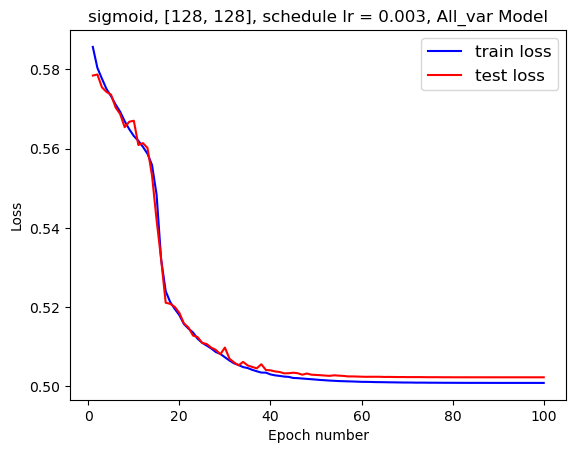

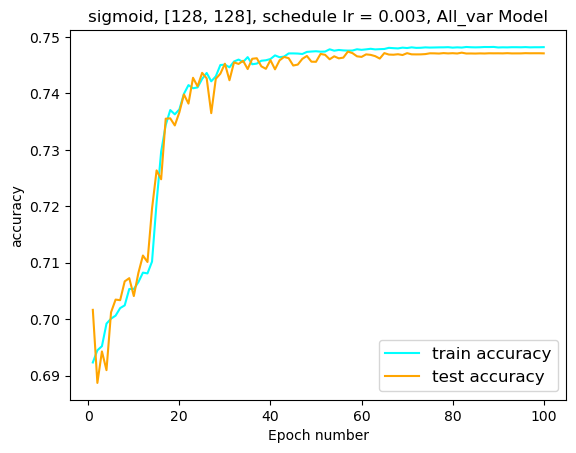

the last 5 average accuracy:  0.7471237540245056
test AUC score 0.8315618112198548


In [119]:
plot(the_fit,', All_var')
print("test AUC score "+str(roc_auc_score(y_true=y_test, y_score=y_pred_test)))
#plot(dR_var[0],', dR_var')
#plot(Mass_var[0],', Mass_var')
#plot(all_var_pt[0],', All_var+pt')

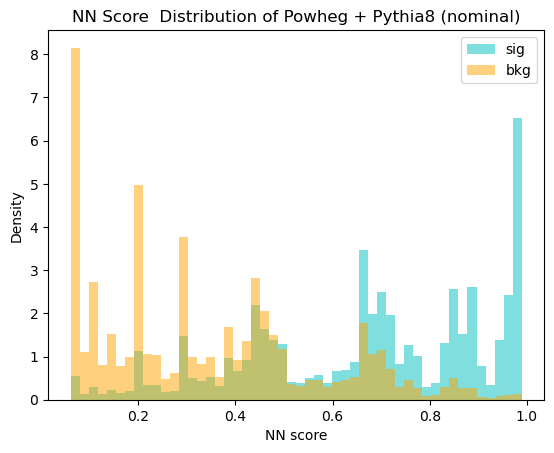

In [118]:
def plot_DNN(ii,source,truth0,shownumber):
    bins = 50
    source_s, source_b = [],[]
    for i in range(len(source)):
        if truth0[i] == 1:source_s.append(source[i])
        else:source_b.append(source[i])
    (n1, bins1, patches1)=plt.hist(source_s,bins = bins,density = True,histtype = 'stepfilled',alpha = 0.5,label = 'sig',color = 'c')
    (n2, bins2, patches2)=plt.hist(source_b,bins = bins,density = True,histtype = 'stepfilled',alpha = 0.5,label = 'bkg',color = 'orange')
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('NN score')
    #axs[0].set_ylim([0, 4])
    #axs[0].set_xscale('log')
    plt.legend()
   # axs[1].set_ylim([0.4, 1.2])
    plt.title("NN Score "+" Distribution of "+ii)    
    if shownumber == 1:
        plt.show()
    else:
        fig.clear()
        plt.close(fig)
        return np.mean(abs_ratio[0]),np.mean(abs_ratio[1])
plot_DNN("Powheg + Pythia8 (nominal)",n_score,n_truth,1)

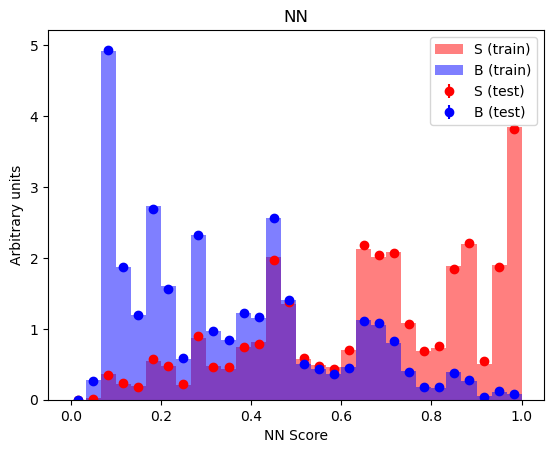

In [135]:
compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN", 
                   weights_train=weights_train.values, weights_test=weights_test.values)

In [14]:
def analyze_file_step1(name):
    filename=(name)
    file = ur.open(filename)
    tree = file["ttbar"]
    fulldata = tree.arrays(library="pd")
    fulldata = fulldata.sample(frac=1).reset_index(drop=True)
    target_eff = 4
    if target_eff == 4: fulldata = fulldata[fulldata.bjet_number>3]  
    else:   fulldata = fulldata[fulldata.bjet_number==3]  
    weights,target,bjet_num,event,pt = extract(fulldata)
    train_size = 0.75 # fraction of sample used for training
    X_train, X_test, y_train, y_test, weights_train, weights_test, num_train, num_test, pt_train, pt_test= \
        train_test_split(fulldata, target, weights, event, pt, train_size=train_size)
    y_train, y_test, weights_train, weights_test, num_train, num_test, pt_train, pt_test = \
        y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
        weights_train.reset_index(drop=True), weights_test.reset_index(drop=True),\
        num_train.reset_index(drop=True),num_test.reset_index(drop=True),\
        pt_train.reset_index(drop=True),pt_test.reset_index(drop=True)
    if name == "3j3b.root":
        X_train_class,X_train_domain = set_zero(X_train)
        X_test_class,X_test_domain = set_zero(X_test)
        X_train_class,X_test_class = trans(X_train_class,X_test_class)
        X_train_domain,X_test_domain = trans(X_train_domain,X_test_domain)
        return X_train_class, X_test_class,X_train_domain, X_test_domain, y_train, y_test, num_train, num_test, pt_train, pt_test
    else: 
        X_train,X_test = trans(X_train,X_test)
        return X_train, X_test, y_train, y_test, num_train, num_test, pt_train, pt_test
def analyze_file_step2(lamda,X_train0, X_test0, y_train0, y_test0, num_train0, num_test0,
                       pt_train0, pt_test0,X_train1, X_test1, y_train1, y_test1, num_train1, 
                       num_test1, pt_train1, pt_test1):
    auc,bias = [],[[],[]]
    model, the_fit = train_DANN(lamda)
    y_pred_test0 = model.predict(X_test0).ravel()
    y_pred_train0 = model.predict(X_train0).ravel()
    y_pred_test1 = model.predict(X_test1).ravel()
    y_pred_train1 = model.predict(X_train1).ravel()
    n_num0 = pd.concat([num_test0.copy(),num_train0.copy()],ignore_index = True)
    n_num1 = pd.concat([num_test1.copy(),num_train1.copy()],ignore_index = True)
    n_score0 = np.concatenate((y_pred_test0.copy(),y_pred_train0.copy()))
    n_score1 = np.concatenate((y_pred_test1.copy(),y_pred_train1.copy()))
    n_truth0 = pd.concat([y_test0.copy(),y_train0.copy()],ignore_index = True)
    n_truth1 = pd.concat([y_test1.copy(),y_train1.copy()],ignore_index = True)
    n_pt0 = pd.concat([pt_test0.copy(),pt_train0.copy()],ignore_index = True)
    n_pt1 = pd.concat([pt_test1.copy(),pt_train1.copy()],ignore_index = True)
    auc_test0 = roc_auc_score(y_true=y_test0, y_score=y_pred_test0)#,sample_weight=weights_test)
    coll_all0 = compute_4eff_comb(n_truth0, n_score0, n_num0, n_pt0, 1)
    auc_test1 = roc_auc_score(y_true=y_test1, y_score=y_pred_test1)#,sample_weight=weights_test)
    coll_all1 = compute_4eff_comb(n_truth1, n_score1, n_num1, n_pt1, 1)
    auc=[auc_test0,auc_test1]
    n_score=[n_score0,n_score1]
    n_truth=[n_truth0,n_truth1]
    if target_eff == 4: plot_range = [0,1,2,3]
    else:plot_range = [0,1,2]
    for i in plot_range:
        x,y,z = check3_pt_bias2(i,coll_all0)
        bias[0].append(x)
    for i in plot_range:
        x,y,z = check3_pt_bias2(i,coll_all1)
        bias[1].append(x)
    return auc,bias,n_score,n_truth
def analyze_file_step3(lamda,X_train0, X_test0,X_train3, X_test3, y_train0, y_test0, num_train0, num_test0,
                       pt_train0, pt_test0,X_train1, X_test1, y_train1, y_test1, num_train1, num_test1, pt_train1, 
                       pt_test1,X_train2, X_test2, y_train2, y_test2, num_train2, num_test2, pt_train2, pt_test2):
    auc,bias = [],[[],[]]
    model, the_fit = train_DANN2(lamda)
    
    y_pred_test0 = model.predict(X_test0).ravel()
    y_pred_train0 = model.predict(X_train0).ravel()
    y_pred_test1 = model.predict(X_test1).ravel()
    y_pred_train1 = model.predict(X_train1).ravel()
    y_pred_test2 = model.predict(X_test2).ravel()
    y_pred_train2 = model.predict(X_train2).ravel()
    y_pred_test3 = model.predict(X_test3).ravel()
    y_pred_train3 = model.predict(X_train3).ravel()
    
    n_num0 = pd.concat([num_test0.copy(),num_train0.copy()],ignore_index = True)
    n_num1 = pd.concat([num_test1.copy(),num_train1.copy()],ignore_index = True)
    n_num2 = pd.concat([num_test2.copy(),num_train2.copy()],ignore_index = True)
    
    n_score0 = np.concatenate((y_pred_test0.copy(),y_pred_train0.copy()))
    n_score1 = np.concatenate((y_pred_test1.copy(),y_pred_train1.copy()))
    n_score2 = np.concatenate((y_pred_test2.copy(),y_pred_train2.copy()))
    n_score3 = np.concatenate((y_pred_test3.copy(),y_pred_train3.copy()))
    
    n_truth0 = pd.concat([y_test0.copy(),y_train0.copy()],ignore_index = True)
    n_truth1 = pd.concat([y_test1.copy(),y_train1.copy()],ignore_index = True)
    n_truth2 = pd.concat([y_test2.copy(),y_train2.copy()],ignore_index = True)
    
    n_pt0 = pd.concat([pt_test0.copy(),pt_train0.copy()],ignore_index = True)
    n_pt1 = pd.concat([pt_test1.copy(),pt_train1.copy()],ignore_index = True)
    n_pt2 = pd.concat([pt_test2.copy(),pt_train2.copy()],ignore_index = True)
    
    auc_test0 = roc_auc_score(y_true=y_test0, y_score=y_pred_test0)#,sample_weight=weights_test)
    coll_all0 = compute_4eff_comb(n_truth0, n_score0, n_num0, n_pt0, 1)
    auc_test1 = roc_auc_score(y_true=y_test1, y_score=y_pred_test1)#,sample_weight=weights_test)
    coll_all1 = compute_4eff_comb(n_truth1, n_score1, n_num1, n_pt1, 1)
    auc_test2 = roc_auc_score(y_true=y_test2, y_score=y_pred_test2)#,sample_weight=weights_test)
    coll_all2 = compute_4eff_comb(n_truth2, n_score2, n_num2, n_pt2, 1)
    auc_test3 = roc_auc_score(y_true=y_test0, y_score=y_pred_test3)#,sample_weight=weights_test)
    coll_all3 = compute_4eff_comb(n_truth0, n_score3, n_num0, n_pt0, 1)
    coll_all = [coll_all0,coll_all1,coll_all2,coll_all3]
    auc=[auc_test0,auc_test1,auc_test2,auc_test3]
    n_score=[n_score0,n_score1,n_score2,n_score3]
    n_truth=[n_truth0,n_truth1,n_truth2,n_truth0]
    if target_eff == 4: plot_range = [0,1,2,3]
    else:plot_range = [0,1,2]
    for j in range(len(n_score)):
        for i in plot_range:
            x,y,z = check3_pt_bias2(i,coll_all[j])
            bias[j].append(x)
    return auc,bias,n_score,n_truth
    

In [1]:
#lamda_list=np.linspace(0,50,num=26)
lamda_list=[[0,0,0]]
X_train0, X_test0,X_train3, X_test3, y_train0, y_test0, num_train0, num_test0, pt_train0, pt_test0=analyze_file_step1("3j3b.root")
X_train1, X_test1, y_train1, y_test1, num_train1, num_test1, pt_train1, pt_test1=analyze_file_step1("3j3b_sherpa.root")
#Pythia8_&_aMC@NLO+Pythia8：set3
X_train2, X_test2, y_train2, y_test2, num_train2, num_test2, pt_train2, pt_test2=analyze_file_step1("3j3b_set3.root")
i=0
num = len(lamda_list)
auc,bias,n_score,n_truth = [0 for _ in range(num)],[0 for _ in range(num)],[0 for _ in range(num)],[0 for _ in range(num)]

NameError: name 'analyze_file_step1' is not defined

In [43]:
print(lamda_list[i])
#auc[i],bias[i],n_score[i],n_truth[i]=analyze_file_step2(lamda_list[i],X_train0, X_test0, y_train0, y_test0, num_train0, num_test0,
#                       pt_train0, pt_test0,X_train1, X_test1, y_train1, y_test1, num_train1, num_test1, pt_train1, pt_test1)
auc[i],bias[i],n_score[i],n_truth[i]=analyze_file_step3(lamda_list[i],X_train0, X_test0,X_train3, X_test3, y_train0, y_test0, num_train0, num_test0,
                       pt_train0, pt_test0,X_train1, X_test1, y_train1, y_test1, num_train1, num_test1, pt_train1, pt_test1,X_train2, X_test2, y_train2, y_test2, num_train2, num_test2, pt_train2, pt_test2)
i+=1

[0, 0, 0]


AttributeError: in user code:

    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nn437\anaconda3\envs\tensorflow-session\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\nn437\AppData\Local\Temp\ipykernel_6960\198969734.py", line 39, in train_step
        ys_disc1 = self.discriminator1_(Xs_enc, training=True)

    AttributeError: 'DANN2' object has no attribute 'discriminator1_'


In [33]:
def plot_NN(ii,source,target,truth0,truth1,shownumber):
    bins = 50
    source_s, source_b, target_s, target_b = [],[],[],[]
    for i in range(len(source)):
        if truth0[i] == 1:source_s.append(source[i])
        else:source_b.append(source[i])
    for i in range(len(target)):            
        if truth1[i] == 1:target_s.append(target[i])
        else:target_b.append(target[i])
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
    (n1, bins1, patches1)=axs[0].hist(source_s,bins = bins,density = True,histtype = 'step',label = 'class_sig',color = 'c')
    (n2, bins2, patches2)=axs[0].hist(source_b,bins = bins,density = True,histtype = 'step',label = 'class_bkg',color = 'orange')
    (n3, bins3, patches3)=axs[0].hist(target_s,bins = bins,density = True,histtype = 'stepfilled',alpha = 0.5,label = 'domain_sig',color = 'c')
    (n4, bins4, patches4)=axs[0].hist(target_b,bins = bins,density = True,histtype = 'stepfilled',alpha = 0.5,label = 'domain_bkg',color = 'orange')
    axs[0].legend()
    axs[0].set_ylabel('Density')
    axs[0].set_ylim([0, 4])
    #axs[0].set_xscale('log')
    axs[0].set(xticklabels=[])
    n = [n1,n2,n3,n4]
    div,abs_ratio = [[],[]],[[],[]]
    for i in range(len(n1)):
        div[0].append(n1[i]/n3[i])
        abs_ratio[0].append(abs(n1[i]/n3[i]-1))
    for i in range(len(n2)):
        div[1].append(n2[i]/n4[i])
        abs_ratio[1].append(abs(n2[i]/n4[i]-1))
    axs[1].plot(div[0],label = 'deviation_sig',color = 'c')
    axs[1].plot(div[1],label = 'deviation_bkg',color = 'orange')
    axs[1].hlines(y = 1, xmin = 0, xmax = 50,color = 'r',linestyles='dashed',label='truth')
    axs[1].set_xlabel("Classifier Score")
    axs[1].set_ylabel('Class/Domain')
    axs[1].legend()
   # axs[1].set_ylim([0.4, 1.2])
    axs[0].title.set_text("NN Score "+" Distribution with \lambda = "+str(ii))    
    if shownumber == 1:
        plt.show()
        print("mean ratio deviation of signal: "+str(round(np.mean(abs_ratio[0]),4)))
        print("mean ratio deviation of background: "+str(round(np.mean(abs_ratio[1]),4)))
    else:
        fig.clear()
        plt.close(fig)
        return np.mean(abs_ratio[0]),np.mean(abs_ratio[1])

In [158]:
sig_dev,bkg_dev = [0 for _ in range(num)],[0 for _ in range(num)]
for i in range(num):sig_dev[i],bkg_dev[i]= plot_NN(lamda_list[i],n_score[i][0],n_score[i][1],n_truth[i][0],n_truth[i][1],0)

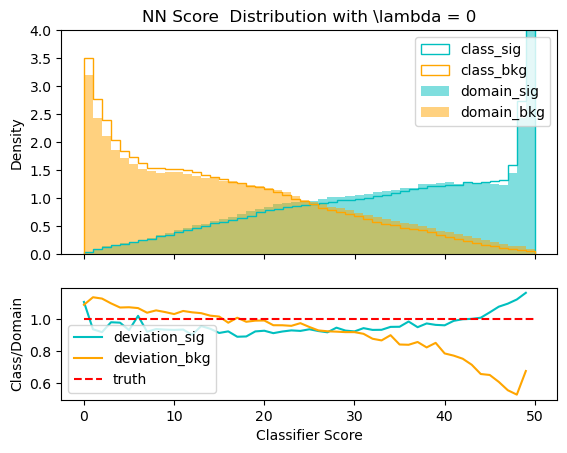

mean ratio deviation of signal: 0.063
mean ratio deviation of background: 0.1243


In [52]:
#for i in [0,1,3,25]:plot_NN(lamda_list[i],n_score[i][0],n_score[i][1],n_truth[i][0],n_truth[i][1],1)
plot_NN(0,n_score[0][0],n_score[0][1],n_truth[0][0],n_truth[0][1],1)

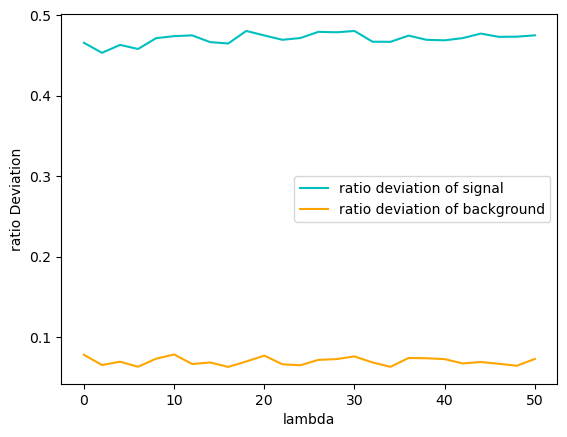

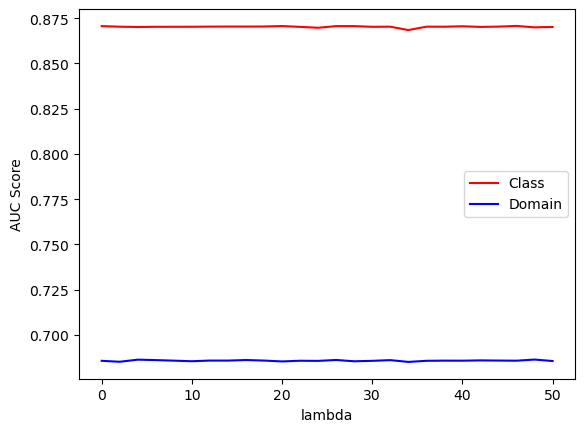

In [159]:
plt.plot(lamda_list,sig_dev,color = 'c',label = 'ratio deviation of signal')
plt.plot(lamda_list,bkg_dev,color = 'orange',label = 'ratio deviation of background')
plt.xlabel('lambda')
plt.ylabel('ratio Deviation')
plt.legend()
plt.show()
auc1 = trans_shape(auc)
plt.plot(lamda_list,auc1[0],color = 'r',label = 'Class')
plt.plot(lamda_list,auc1[1],color = 'b',label = 'Domain')
plt.xlabel('lambda')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [23]:
def print_eff(n_score):
    coll_all = compute_4eff_comb(n_truth, n_score, n_num, n_pt, 1)
    print("Efficiency of Leading pT b-jet from tops:", round(coll_all[0][0],3))
    print("Efficiency of sub-Leading pT b-jet from tops:", round(coll_all[0][1],3))
    print("Efficiency of Leading pT b-jet additional:", round(coll_all[0][2],3))
    print("Efficiency of sub-Leading pT b-jet additional:", round(coll_all[0][3],3))
    print('both from top are assigned correctly:', round(coll_all[0][5],3))
    return coll_all
coll_class = print_eff(n_score_class)
coll_domain = print_eff(n_score_domain)

Efficiency of Leading pT b-jet from tops: 0.809
Efficiency of sub-Leading pT b-jet from tops: 0.711
Efficiency of Leading pT b-jet additional: 0.769
Efficiency of sub-Leading pT b-jet additional: 0.77
both from top are assigned correctly: 0.646
Efficiency of Leading pT b-jet from tops: 0.81
Efficiency of sub-Leading pT b-jet from tops: 0.711
Efficiency of Leading pT b-jet additional: 0.769
Efficiency of sub-Leading pT b-jet additional: 0.77
both from top are assigned correctly: 0.647


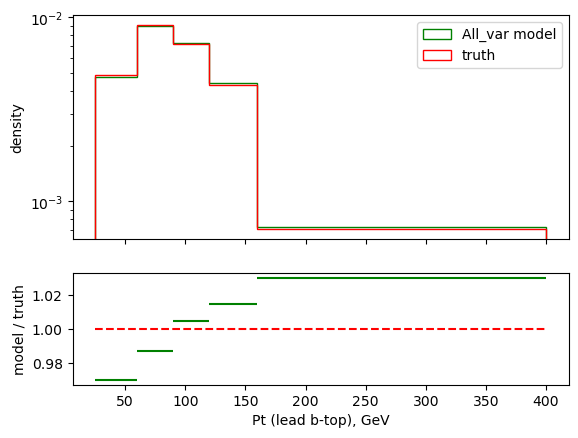

deviation of All_var model: 0.046710492410468936
weighted deviation of All_var model: 0.600807062535683
slope of pT bias ratio:  0.00023129560522866798
chi square:  0.0003611782745739305


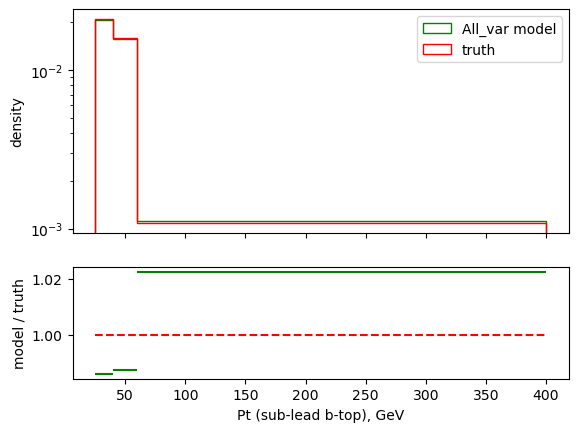

deviation of All_var model: 0.02936953170033939
weighted deviation of All_var model: 2.1737875651215326
slope of pT bias ratio:  0.0001891429554580891
chi square:  2.243793729804903e-06


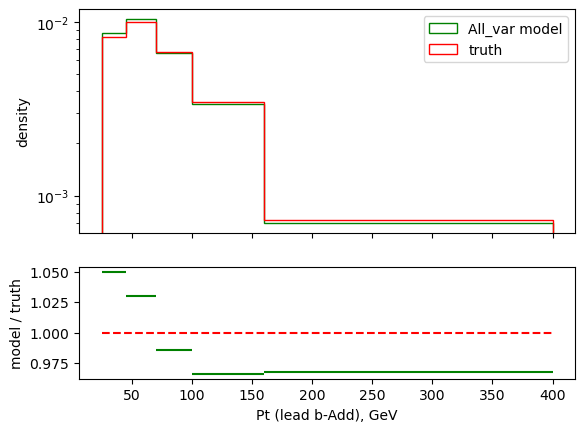

deviation of All_var model: 0.07610878805441693
weighted deviation of All_var model: 2.3992103981899713
slope of pT bias ratio:  -0.000294047077257831
chi square:  0.002496215535862014


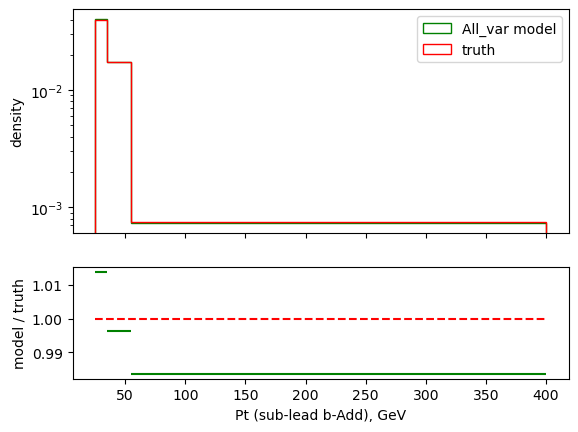

deviation of All_var model: 0.021852297070419927
weighted deviation of All_var model: 5.537619463059187
slope of pT bias ratio:  -0.00011808261974332942
chi square:  0.00012676115291988395


In [36]:
for i in [0,1,2,3]:
    check3_pt_bias2(i,coll_class)
    #check3_pt_bias2(i,coll_domain)

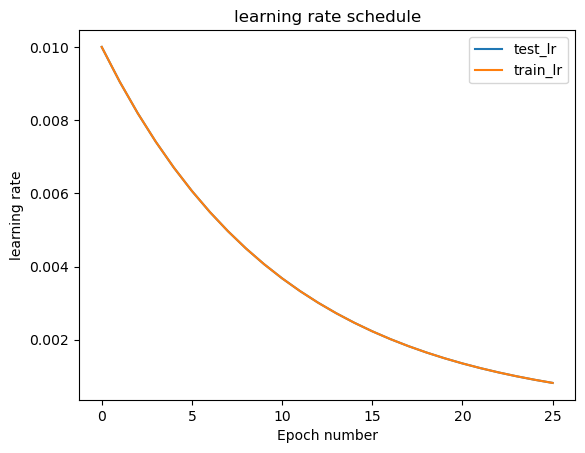

In [17]:
def plot_lr(the_fit):
    plt.plot(the_fit.history['val_lr'],label='test_lr')
    plt.plot(the_fit.history['lr'],label='train_lr')
    plt.title('learning rate schedule')
    plt.xlabel('Epoch number')
    plt.ylabel('learning rate')
    plt.legend()
    plt.show()
plot_lr(the_fit)

In [21]:
#when three b-jet under cut, consider the highest score one as additional
def compute_4eff_3b4b(dataset, NNscore,event,n_pt,cut):
    copy = event.copy()
    event_number = len(set(copy))
    bjetpt_model = [[] for _ in range(4)] #lead_top, sub_top, lead_add, sub_add
    bjetpt_truth = [[] for _ in range(4)]
    n = [[0 for _ in range(4)],[0 for _ in range(4)]]
    lead_top, sub_top,lead_add, sub_add=[0,0],[0,0],[0,0],[0,0]
    tot_cut, tot_cor, both_top_cor = [0,0],[0,0],[0,0]
    #coll = [[] for _ in range(event_number)]
    coll = [[] for _ in range(max(set(copy)))]
    for i in range(len(dataset)):
        coll[int(event[i])-1].append([NNscore[i], dataset[i], n_pt[i]])
    n3,n4=0,0    
   # for i in range(event_number):
    for i in range(max(set(copy))):
        score_top = []
        index_top = []
        index_add = []
        score_add = []
        score = []
        pt = []
        index_0 = []
        index_1 = []
        pt_top =[]
        pt_add = []
        num_bjet = len(coll[i])
        #print(num_bjet)
        if num_bjet == 3:
            bcase = 0
            n3 += 1
        else: 
            bcase = 1
            n4 += 1
        for j in range(num_bjet):
            score.append(coll[i][j][0])
            pt.append(coll[i][j][2])
            if coll[i][j][1] == 0: 
                pt_top.append(coll[i][j][2])
                index_0.append(j)
            else: 
                pt_add.append(coll[i][j][2])
                index_1.append(j)
            if coll[i][j][0] <= cut: 
                score_top.append(coll[i][j][0])
            else: score_add.append(coll[i][j][0])
        
        # tops by NN algorithm
        if len(score_top) == 0:
            fir_top_NN = -1
            sec_top_NN = -1
        elif len(score_top) == 1:
            fir_top_NN = score.index(score_top[0])
            sec_top_NN = -1
            index_top.append(fir_top_NN)
        else:
            for z in range(2):
                mini = min(score_top)
                index_top.append(score.index(mini))
                score_top.remove(mini)
            if len(score_top) > 0:
                for z in score_top:
                    score_add.append(z)  
            if pt[index_top[0]] >= pt[index_top[1]]:
                fir_top_NN = index_top[0]
                sec_top_NN = index_top[1]
            else:
                fir_top_NN = index_top[1]
                sec_top_NN = index_top[0]
       
        # tops by truth information
        pt_top.sort()
        if len(pt_top) > 0: 
            fir_top_truth = pt.index(pt_top[-1])
            if bcase == 0:
                bjetpt_truth[0].append(pt_top[-1]/1000)
        else: fir_top_truth = -1
        if len(pt_top) > 1: 
            sec_top_truth = pt.index(pt_top[-2])
            if bcase == 0:
                bjetpt_truth[1].append(pt_top[-2]/1000)
        else: sec_top_truth = -1
        
        
        # add by NN algorithm
        if len(score_add) == 0:
            fir_add_NN = -1
            sec_add_NN = -1
        elif len(score_add) == 1:
            fir_add_NN = score.index(score_add[0])
            sec_add_NN = -1
            index_add.append(fir_add_NN)
        else:
            ptadd = []
            for z in score_add:
                ptadd.append(coll[i][score.index(z)][2])
                index_add.append(score.index(z))
            ptadd.sort()
            fir_add_NN = pt.index(ptadd[-1])
            sec_add_NN = pt.index(ptadd[-2])

        # add by truth information
            
        pt_add.sort()
        if len(pt_add) > 0: 
            fir_add_truth = pt.index(pt_add[-1])
            if bcase == 0:
                bjetpt_truth[2].append(pt_add[-1]/1000)
        else: fir_add_truth = -1
        if len(pt_add) > 1: 
            sec_add_truth = pt.index(pt_add[-2])
            if bcase == 0:
                bjetpt_truth[3].append(pt_add[-2]/1000)
        else: sec_add_truth = -1
        
        #compute eff of cut
        x = len(common_member(index_add, index_1))
        y = len(common_member(index_top, index_0))
        tot_cut[bcase] += len(index_1)+len(index_0)
        tot_cor[bcase] += x + y
        if y == 2: both_top_cor[bcase] += 1
        
        #compare NN and truth
        if fir_top_NN != -1:
            n[bcase][0] += 1
            if bcase == 0:
                bjetpt_model[0].append(pt[fir_top_NN]/1000)
            if fir_top_NN == fir_top_truth: lead_top[bcase] += 1
        if sec_top_NN != -1:
            n[bcase][1] += 1
            if bcase == 0:
                bjetpt_model[1].append(pt[sec_top_NN]/1000)
            if sec_top_NN == sec_top_truth: sub_top[bcase] += 1
        if fir_add_NN != -1:
            n[bcase][2] += 1
            if bcase == 0:
                bjetpt_model[2].append(pt[fir_add_NN]/1000)
            if fir_add_NN == fir_add_truth: lead_add[bcase] += 1
        if sec_add_NN != -1:
            n[bcase][3] += 1
            if bcase == 0:
                bjetpt_model[3].append(pt[sec_add_NN]/1000)
            if sec_add_NN == sec_add_truth: sub_add[bcase] += 1
    eff = [lead_top[0]/n[0][0], sub_top[0]/n[0][1],lead_add[0]/n[0][2],0,tot_cor[0]/tot_cut[0], both_top_cor[0]/n3]
          # [lead_top[1]/n[1][0], sub_top[1]/n[1][1],lead_add[1]/n[1][2],sub_add[1]/n[1][3],tot_cor[1]/tot_cut[1], both_top_cor[1]/n4]]
    correct_num = [eff, bjetpt_model, bjetpt_truth]
    return correct_num

In [22]:
def print_eff_4b(n,cut):
    collection42 = compute_4eff_comb(n[1][0], n[1][1], n[1][2], n[1][3], cut)
    print("Efficiency of Leading pT b-jet from tops:", collection42[0][0])
    print("Efficiency of sub-Leading pT b-jet from tops:", collection42[0][1])
    print("Efficiency of Leading pT b-jet additional:", collection42[0][2])
    print("Efficiency of sub-Leading pT b-jet additional:", collection42[0][3])
    print('both from top are assigned correctly:', collection42[0][5])
    print('combinal eff by cut:', collection42[0][4])
    return collection42
def print_eff_3b(n,cut):
    collection_3b4b = compute_4eff_3b4b(n[1][0], n[1][1], n[1][2], n[1][3], cut)
    print("Efficiency of Leading pT b-jet from tops:", collection_3b4b[0][0])
    print("Efficiency of sub-Leading pT b-jet from tops:", collection_3b4b[0][1])
    print("Efficiency of Leading pT b-jet additional:", collection_3b4b[0][2])
    print("Efficiency of sub-Leading pT b-jet additional:", collection_3b4b[0][3])
    print('both from top are assigned correctly:', collection_3b4b[0][5])
    print('combinal eff by cut:', collection_3b4b[0][4],"\n")
    return collection_3b4b


In [40]:
if target_eff == 3:
    coll_all = print_eff_3b(all_var,1)
    coll_dR =  print_eff_3b(dR_var,1)
    coll_mass = print_eff_3b(Mass_var,1)
    coll_pt = print_eff_3b(all_var_pt,1)
if target_eff == 4:
    coll_all = print_eff_4b(all_var,1)
    coll_dR =  print_eff_4b(dR_var,1)
    coll_mass = print_eff_4b(Mass_var,1)
    coll_pt = print_eff_4b(all_var_pt,1)
coll = [coll_all,coll_dR,coll_mass,coll_pt]

NameError: name 'all_var' is not defined

In [27]:
colors = ['r','g','b','y','c']
labels = ['truth','All_var model','dR model','Mass model','All_var + pt model']
def check3_pt_bias(x):
    bins=[[25,60,90,120,160,400],[25,40,60,400],[25,45,70,100,160,400],[25,35,55,400]]
    name = ['lead b-top','sub-lead b-top','lead b-Add','sub-lead b-Add']
    biahist=[coll_all[2][x],coll_all[1][x],coll_dR[1][x],coll_mass[1][x],coll_pt[1][x]]
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
    (n, bins, patches)=axs[0].hist(biahist, bins[x],color=colors, range =[0,400], 
                            density=True, histtype='step',label=labels)
    axs[0].legend()
    axs[0].set_ylabel('density')
    axs[0].set_yscale('log')
    #axs[0].set_xscale('log')
    axs[0].set(xticklabels=[])
    ratio,div,wdiv = [[] for i in range(len(labels)-1)],[0 for i in range(len(labels)-1)],[0 for i in range(len(labels)-1)]
    for i in range(len(n[0])):
        for j in range(len(coll)):
            ratio[j].append(n[j+1][i]/n[0][i])
            div[j] += (ratio[j][i]-1)**2
            wdiv[j] += ((ratio[j][i]-1)*n[0][i]/(bins[i+1]-bins[i]))**2
            axs[1].hlines(y = ratio[j][i], xmin = bins[i], xmax = bins[i+1],color=colors[j+1],label=labels[j+1])
    axs[1].hlines(y = 1, xmin = bins[0], xmax = bins[-1],color = 'r',linestyles='dashed',label='truth')
    axs[1].set_xlabel('Pt ('+name[x]+'), GeV')
    axs[1].set_ylabel('model / truth')
    #axs[1].set_xscale('log')
    #axs[1].set_xticks(bins[x], bins[x],fontsize=7)
    plt.show()
    print("deviation of All_var model:",np.sqrt(div[0]))
    print("deviation of dR model:",np.sqrt(div[1]))
    print("deviation of Mass model:",np.sqrt(div[2]))
    print("deviation of All_var+pt model:",np.sqrt(div[3]),"\n")
    print("weighted deviation of All_var model:",1e5*np.sqrt(wdiv[0]))
    print("weighted deviation of dR model:",1e5*np.sqrt(wdiv[1]))
    print("weighted deviation of Mass model:",1e5*np.sqrt(wdiv[2]))
    print("weighted deviation of All_var+pt model:",1e5*np.sqrt(wdiv[3]))

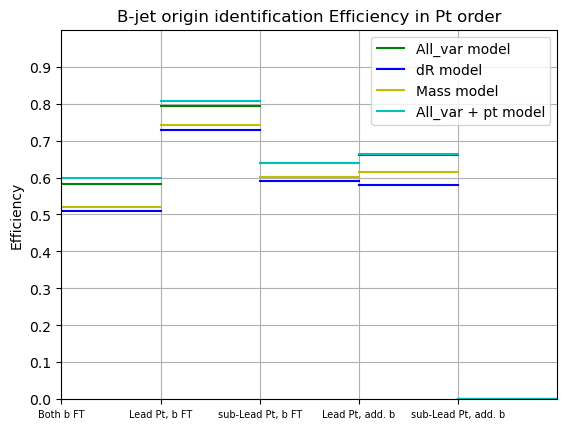

In [38]:
my_xticks = ['Both b FT','Lead Pt, b FT','sub-Lead Pt, b FT','Lead Pt, add. b','sub-Lead Pt, add. b']
xx = [0.2*i for i in range(5)]
for i in [-1,0,1,2]:
    plt.axhline(y = coll[i+1][0][3], xmin = 4/5, xmax = 1,color=colors[i+2],label=labels[i+2])
    for j in range(len(coll)):
        plt.axhline(y = coll[j][0][i], xmin = (i+1)/5, xmax = (i+2)/5,color=colors[j+1])
ax = plt.gca()
#ax.get_xaxis().set_visible(False)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(xx, my_xticks,fontsize=7)
plt.grid()
plt.title('B-jet origin identification Efficiency in Pt order')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

In [31]:
my_xticks = ['Both b FT','Lead Pt, b FT','sub-Lead Pt, b FT','Lead Pt, add. b','sub-Lead Pt, add. b']
xx = [0.2*i for i in range(5)]
def plot3b4b(collection,bcase,name):
    for i in [-1,0,1,2]:
        plt.axhline(y = collection[0][bcase][i], xmin = (i+1)/5, xmax = (i+2)/5,color='r')
    plt.axhline(y = collection[0][bcase][3], xmin = 4/5, xmax = 1,color='r',label='reco level')
    plt.yticks(np.arange(0, 1, 0.1))
    plt.grid()
    plt.xticks(xx, my_xticks,fontsize=7)
    plt.title('B-jet origin identification Efficiency in Pt order ('+name+')')
    plt.ylabel('Efficiency')
    plt.legend()
    plt.show()
plot3b4b(collection_3b4b_14,0,'== 3b in All_var model')
plot3b4b(collection_3b4b_14,1,'>= 4b in All_var model')
plot3b4b(collection_3b4b_8,0,'== 3b in dR model')
plot3b4b(collection_3b4b_8,1,'>= 4b in dR model')

NameError: name 'collection_3b4b_14' is not defined

In [ ]:
#cut_candidate = np.linspace(0.01, 1, 100)
cut_candidate = np.linspace(0.1, 1, 91)
coll2, cut_eff_com2= [],[]
for i in cut_candidate:
 #   x = compute_4eff_cut(n_truth, n_score, n_num, n_pt, i)
    y = compute_4eff_comb(n_truth, n_score2, n_num, n_pt, i)
 #   coll1.append(x)
    coll2.append(y)
 #   cut_eff_top1.append(x[4])
 #   cut_eff_top2.append(y[4])
 #   cut_eff_add1.append(x[5])
 #   cut_eff_add2.append(y[5])
 #   cut_eff_com1.append(x[6])
    cut_eff_com2.append(y[6])
    

In [ ]:
#plt.plot(cut_candidate,cut_eff_add2,label='add efficiency',color='red')
#plt.plot(cut_candidate,cut_eff_top2,label='top efficiency',color='blue')
plt.plot(cut_candidate,cut_eff_com2,label='combination efficiency',color='green')
plt.xlabel("optimal cut")
plt.ylabel("Efficiency of cut")
plt.title('no more than 2 b-jet assigned to tops under cut')
plt.legend()
plt.show()
#print('maximum top efficiency/blue:', max(cut_eff_top2), 'when cut =', cut_candidate[cut_eff_top2.index(max(cut_eff_top2))])
#print('maximum add efficiency/red:', max(cut_eff_add2), 'when cut =', cut_candidate[cut_eff_add2.index(max(cut_eff_add2))])
print('maximum combination efficiency/green:', max(cut_eff_com2), 'when cut =', cut_candidate[cut_eff_com2.index(max(cut_eff_com2))])

In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
fpr2,tpr2,_ = roc_curve(y_true=y_train, y_score=y_pred_train,sample_weight=weights_train)
plt.plot(fpr, tpr, color='blue',lw=2,label='test')
plt.plot(fpr2, tpr2, color='red',lw=2,label='train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver Operating Characteristic')

In [ ]:
int_pred_test_sig = [weights_test[(y_test ==1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
Z = max(vamsasimov)
print("Z:",Z)

In [ ]:
plt.plot(np.linspace(0,1,num=50),vamsasimov, label='Significance (Z = {})'.format(np.round(Z,decimals=2)))


plt.title(act_f + " NN Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
#plt.savefig("Significance_xgb.pdf")
plt.show()

In [76]:
num1 = 21
coll_lambda = np.linspace(0.5,0.7,num=num1)
print(coll_lambda)
auc = [0 for i in range(num1)]
bias,slope,chi2 = auc.copy(),auc.copy(),auc.copy()
z=0

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7 ]


In [77]:
print(bias)
print(slope)
print(chi2)
#print(auc)
#print(coll_lambda)
#coll_lambda = list(coll_lambda)
#coll_lambda.append(2.1)
#auc.append(0)
#coll_eff.append(0)
#bias.append(0)
#slope.append(0)
#chi2.append(0)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [98]:
print(coll_lambda[z])
auc[z],bias[z],slope[z],chi2[z]= scan_lambda(coll_lambda[z],X_train_class,X_train_domain,X_test_class,X_test_domain, 
        y_train, y_test, num_train, num_test, pt_train, pt_test)
z += 1

0.7


In [108]:
def trans_shape(data):
    result=[[] for _ in range(len(data[0]))]
    for i in range(len(data[0])):
        for j in range(len(data)):
            result[i].append(data[j][i])
    return result
def plot_scan_lambda(auc,bias,slope,chi2):
    name = ["1st FT",'2nd FT','1st Add','2nd Add']
    colors=['r','orange','b','c']
    auc = trans_shape(auc)
    bias = trans_shape(bias)
    slope =trans_shape(slope)
    chi2=trans_shape(chi2)
    for i in range(4):
        plt.plot(coll_lambda,bias[i],color=colors[i],label=name[i])
    plt.xlabel("lambda")
    plt.ylabel("Weighted Bias")
    plt.title("At least four b-jets (None vs pT)")
    plt.yscale("log")
    plt.legend()
    plt.show()
   # plt.plot(coll_lambda,auc[2],label='train mode')
   # plt.plot(coll_lambda,auc[0],label='test mode')
   # plt.ylabel("AUC")
   # plt.xlabel("lambda")
   # plt.legend()
  #  plt.show()
    for i in range(4):
        plt.plot(coll_lambda,slope[i],color=colors[i],label=name[i])
    plt.xlabel("lambda")
    plt.ylabel("slope")
    plt.legend()
    plt.show()
    for i in range(4):
        plt.plot(coll_lambda,chi2[i],color=colors[i],label=name[i])
    plt.xlabel("lambda")
    plt.ylabel("chi2")
    plt.legend()
    plt.show()
#plot_scan_lambda(auc,bias,slope,chi2)